

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Subsurface Data Analytics 

### Physics Constrain Dinamic Time Warping Worflow Demostration

#### Jose Luis Hernandez Mejia, PhD Student, The University of Texas at Austin
#### [LinkedIn](https://linkedin.com/in/joseherme) | [Twitter](https://twitter.com/jlhermejia) | [GitHub](https://github.com/JoseLuisHerme) 
#### Jesse Pisel, Ph.D., P.Geo., Assistant Professor of Practice, The University of Texas at Austin, College of Natural Science,

#### Michael Pyrcz, Associate Professor,The University of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)


#### Work completed as part of the DIRECT consortium for Subsurface Data Analytics and Machine Learning

#### Executive Summay
Waterflooding is the most used secondary method for oil recovery. Therefore, define the optimal injection well locations are crucial to achieve higher recovery factors. Well location optimization is specially challenging because of the interference of injector and producing wells. Several techniques have been developed to evaluate the connectivity between injectors and producing wells, such as correlation coefficients, linear regression models, and capacitance resistance models. However, such methods rely on limited flow physics and are based on previous assumptions about the data.

In this work, we propose a novel technique using a physics constrain dynamic time warping algorithm (DTW) to detect the influence of injector wells on oil production response. The objective of this algorithm is to match the well injection and production wells to determine the lag time between the beginning of the injection with the oil production response. This method opens the possibility to efficiently determine the lag time between water injection and the oil production response. The lag time is used to characterize the reservoir formation connectivity and heterogeneity between injector and producer wells. Our proposed method applies dynamic time warping to this application with enhancements to integrate physics-based constraints for subsurface flow through porous media to improve accuracy, avoid incorrect matches or unphysical results and reduce uncertainty.  Additionally, there is no need to make previous assumptions about the data and the method is robust in the presence single noise. 


#### Import required libraries 

In [1]:
import numpy as np #Array operations
import matplotlib.pyplot as plt #Plotting 
import pandas as pd #To handle dataframes
import scipy.spatial #Spatial calculations
import math #Mathematical Operations 
from sklearn.metrics import mean_squared_error #Evalute MSE between water injection and optimal match 

#### Load example datafiles 
Import synthetic data files of two time series with different time lenght  

In [2]:
df1 = pd.read_csv('Time_series_1.csv') #Water injection
df2 = pd.read_csv('Time_series_2.csv') #Oil production

#### Functions Section
Functions used during the worflow to calculate and plot results from classical DTW algorithm and physics constrain DTW

In [3]:
def norm(X):
    """Normilize time series from 0 to 1 range
    Args:
        X: Numpy array of the time series
    Returns:
        Xn: Normilized time series from 0 to 1 
    """
    maxx=np.max(X)
    minn=np.min(X)
    rangee=maxx-minn
    Xn=(X-minn)/rangee
    return Xn

def optimal_path_plot(X,Y,P,D):
    """Creates a vizual representation of the optimal warping path
    Args:
        X: Normilized water injection time series
        Y: Normilized oil production time series
        P: Optimal Warping path
        D: Cumulative cost matrix
    Returns:
    Tree way plot of the optimal warping path 
    """
    from matplotlib.gridspec import GridSpec
    fig = plt.figure(figsize=(10, 6))
    gs = GridSpec(2,2,width_ratios=[1, 4])

    ax_joint = fig.add_subplot(gs[0,1])
    ax_marg_x =  fig.add_subplot(gs[1,1])
    ax_marg_y = fig.add_subplot(gs[0,0])

    iny=np.arange(0,len(Y),1)
    prd=np.arange(0,len(X),1)
    ax_joint.imshow(D, origin='lower', aspect='equal',cmap='viridis')
    ax_joint.plot(P[:, 1], P[:, 0], color='red',lw=2,label='Optimal Warping Path')
    ax_joint.legend()
    ax_marg_x.plot(iny,Y,color='black',marker='o',markersize='2',linewidth='1')
    ax_marg_y.plot(X,prd,color='gray',linestyle='--',marker='o',markersize='2',linewidth='1')

    # Turn off tick labels on marginals
    plt.setp(ax_marg_x.get_xticklabels(), visible=True)
    plt.setp(ax_marg_y.get_yticklabels(), visible=True)

    # Set labels on marginals
    ax_marg_y.set_ylabel('Normilized water injection time index')
    ax_marg_x.set_xlabel('Normilized oil production time index')
    plt.show()
    
def compute_accumulated_cost_matrix(C,step_size=1):
    """Compute the accumulated cost matrix given the cost matrix with a different step size constrain 21
    Args:
        C: cost matrix
        step_size: Step_size in the minimization distance
    Returns:
        D: Accumulated cost matrix
    """
    N = C.shape[0]
    M = C.shape[1]
    D = np.zeros((N, M))
    D[0, 0] = C[0, 0]
    for n in range(1, N):
        D[n, 0] = D[n-1, 0] + C[n, 0]
    for m in range(1, M):
        D[0, m] = D[0, m-1] + C[0, m]
    for n in range(1, N):
        for m in range(1, M):
            D[n, m] = C[n, m] + min(D[n-1, m], D[n, m-1], D[n-1, m-1])
    return D

def compute_optimal_warping_path_subsecuent(D,step_size=1):
    """Given an accumulated cost matrix, Compute the warping path for clasical subsequence dynamic time warping for
    step sizes
    Args:
        D: Accumulated cost matrix
        step_size: Step_size of the minimazion process

    Returns
        P: Warping path (list of index pairs)
    """
    if step_size==1:
        N, M = D.shape
        n = N - 1
        m = D[N - 1, :].argmin()
        P = [(n, m)]

        while n > 0:
            if m == 0:
                cell = (n - 1, 0)
            else:
                val = min(D[n-1, m-1], D[n-1, m], D[n, m-1])
                if val == D[n-1, m-1]:
                    cell = (n-1, m-1)
                elif val == D[n-1, m]:
                    cell = (n-1, m)
                else:
                    cell = (n, m-1)
            P.append(cell)
            n, m = cell
        P.reverse()
        return np.array(P)
    
    elif step_size==2:
        N, M = D.shape
        n = N - 1
        m = D[N - 1, :].argmin()
        P = [(n, m)]

        while n > 0 or m > 0:
            if n == 0:
                cell = (0, m - 1)
            elif m == 0:
                cell = (n - 1, 0)
            else:
                val = min(D[n-1, m-1], D[n-2, m-1], D[n-1, m-2])
                if val == D[n-1, m-1]:
                    cell = (n-1, m-1)
                elif val == D[n-2, m-1]:
                    cell = (n-2, m-1)
                else:
                    cell = (n-1, m-2)
            P.append(cell)
            (n, m) = cell
        P.reverse()
        return np.array(P)
    
    elif step_size==3:
        N, M = D.shape
        n = N - 1
        m = D[N - 1, :].argmin()
        P = [(n, m)]

        while n > 1 or m > 1:
            if n == 0:
                cell = (0, m - 1)
            elif m == 0:
                cell = (n - 1, 0)
            else:
                val = min(D[n-3, m-1], D[n-1, m-1], D[n-1, m-3])

                if val == D[n-3, m-1]:
                    cell = (n-3, m-1)

                elif val == D[n-1, m-1]:
                    cell = (n-1, m-1)

                else:
                    cell = (n-1, m-3)
            P.append(cell)
            (n, m) = cell
        P.reverse()
        return np.array(P)
    
def aligment_plot(X,Y,P,offset):
    """Plot the time series aligment given the optimal warping path
    Args:
        X: Normilized water injection
        Y: Normilized oil production
        P: Optimal warping path
        offset: Re-scale the time series for better vizualuzation. Recomended value = 1 
    Returns
        Optimal time series aligment plot
    """
    xmin=np.min(X)
    xmax=np.max(X)
    xrange=xmax-xmin
    xn=(X-xmin)/(xrange)
    iny=np.arange(0,len(Y),1)
    inx=np.arange(0,len(X),1)
    yn=((Y-xmin)/(xrange))+offset
    plt.figure(figsize=(10, 4))
    plt.plot(inx,xn,color='gray',linestyle='--',marker='o',markersize='2',linewidth='1',label='Normilized water injection')
    plt.plot(iny,yn,color='black',marker='o',markersize='2',linewidth='1',label='Normilized oil production ')
    plt.xlabel('Time Index')
    plt.ylabel('Offset normilized oil prodiction and water injection')
    
    for i in range(len(P)):
        plt.plot([P[:,0][i], P[:,1][i]],[xn[P[:,0][i]],yn[P[:,1][i]]],color='Black',ls='--',lw=1)
    plt.legend();
    
def slope(lp,sp):
    """Calculate the slope between a starting point and all the subsecuent points of the allowed serch space.
    Function used inside the constrain DTW Algorithm 
    Arguments:
        lp: Startin point          
        sp: search space 
    Returns:
        angles: Deviation angle between the starting point and all the subsecuent points in the allowed serch space
        sp: Slopes between a starting point and all the points in the allowed search space
    """
    slopes=[]
    for i in sp:     
        m=(lp[0]-i[0])/(lp[1]-i[1])
        slopes.append(m)
        
    angles=[]
    for m in slopes:
        ang=math.degrees(math.atan(m))
        angles.append(ang)
    
    angles=np.array(angles).reshape(-1,1)    
    return angles,sp

def dtw_constrain(X,Y,alpha,ome):
    """Calculates the optimal warping path between normilized water injection and oil production given
        hyperparamters alpha and omega 
    Args:
        X: Normilized water injection
        Y: Normilized oil production
        alpha: Search space constrain
        ome: Angle constrain
    Returns
        P: Warping path (list of index pairs)
    """
    C = scipy.spatial.distance.cdist(X, Y, 'euclidean') 
    #Construct cummulative cost matrix depending on alpha value
    N, M = C.shape
    delta=(alpha-1)
    Ni=N+delta
    Mi=M+delta
    Di = np.zeros((Ni, Mi))
    Di[delta:,delta] = np.cumsum(C[:, 0])
    Di[delta, delta:] = C[0, :]
    for n in range(delta+1, Ni):
        for m in range(delta+1, Mi):
            s_p=[]
            for i in range(alpha):
                for j in range(alpha):
                    s_p.append([n-1-i,m-1-j])
            sp=np.array(s_p)
            val=[]
            for i in range(len(sp)):
                val.append(Di[sp[i][0],sp[i][1]])
            Di[n, m] = C[n-delta, m-delta] + min(val)
    Di_beta= Di[delta:, delta:]
    
    ##Constrain back-in time
    for i in range(Di_beta.shape[0]):
        for j in range(Di_beta.shape[0]):
            if i<j:
                Di_beta[j,i]=np.inf
            else:
                pass
    ##Warping path
    N, M =  Di_beta.shape
    n = N - 1
    m = Di_beta[N - 1, :].argmin() #Warping path initizalization
    
    P_beta = [(n, m)]
    while n > 0:
        if m == 0:
            cell = (n - 1, 0)
        else:
            s_p=[]
            for i in range(alpha):
                for j in range(alpha):
                    s_p.append([n-1-i,m-1-j])
            search_space=np.array(s_p)
            
            ip=[n,m]
            angles,sp_upd=slope(ip,search_space)
            
            sp_new=[]
            up_boundary=45+ome
            lower_boundary=45-ome
            for a,b in zip(angles,sp_upd):
                if (a<=up_boundary) and (a>=lower_boundary): 
                    sp_new.append(b)
                else:
                    pass
            sp=np.array(sp_new) 
                    
            val=[]
            for i in range(len(sp)):
                val.append(Di_beta[sp[i][0],sp[i][1]])
            
            sor_val=pd.DataFrame(val,columns=['Val'])
            sor_val['cell']=sp_new
            sor_val_sort=sor_val.sort_values(by=['Val']).reset_index()
            cell_in=sor_val_sort['cell'][0]
            n=cell_in[0]
            m=cell_in[1]
            cell = (n, m)
        P_beta.append(cell)
        n, m = cell
    P_beta.reverse()
    P_beta=np.array(P_beta)        
    return  P_beta, Di_beta


def cosine_similarity(u, v):
    """Cosine similarity reflects the degree of similarity between X and Y
    Arguments:
        X: Normilized water injection         
        Y: Normilized oil production
    Returns:
        cosine_similarity:  the cosine similarity between X and Y.
    """
    # Compute the dot product between u and v 
    dot = np.dot(u,v)
    # Compute the L2 norm of u
    norm_u = np.sqrt(np.sum(u**2))
    # Compute the L2 norm of v
    norm_v =  np.sqrt(np.sum(v**2))
    # Compute the cosine similarity 
    cosine_similarity = dot/(norm_v*norm_u)
    return cosine_similarity

def hyperparameter_tunning_plots(cost,mse,sim,matched_points):
    """plot the cost, mse, sim and number of matched_points during hyperparameter tunning
    Arguments:
        cost: Cost matrix with dimentions dim(search_space,angle constrains)        
        mse: Mean squared error matrix with dimentions dim(search_space,angle constrains)  
        sim: cosine similarity matrix with dimentions dim(search_space,angle constrains) 
        matched_points: Number of points mateched during DTW matrix with dimentions dim(search_space,angle constrains)
    Returns:
        Plots of evaluation metrics vs hyperparamters 
    """
    
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(221)
    im2=plt.imshow(cost.T, aspect='equal',cmap='viridis')
    cbar2=plt.colorbar(im2,fraction=0.046, pad=0.04)
    cbar2.set_label('Cost', rotation=270, fontsize = 11, labelpad=10)
    plt.ylabel('Angle constrain', fontsize = 11)
    plt.autoscale(True)
    plt.yticks(range(len(ang)),np.round(ang, 1), fontsize = 8)
    plt.xticks(range(len(ss)),ss, fontsize = 8)

    ax2 = fig.add_subplot(222)
    im2=plt.imshow(mse.T, aspect='equal',cmap='viridis')
    cbar2=plt.colorbar(im2,fraction=0.046, pad=0.04)
    cbar2.set_label('MSE', rotation=270, fontsize = 11, labelpad=10)
    plt.autoscale(True)
    plt.yticks(range(len(ang)),np.round(ang, 1), fontsize = 8)
    plt.xticks(range(len(ss)),ss, fontsize = 8)

    ax3 = fig.add_subplot(223)
    im2=plt.imshow(sim.T, aspect='equal',cmap='viridis')
    cbar2=plt.colorbar(im2,fraction=0.046, pad=0.04)
    cbar2.set_label('Cosine Similarity', rotation=270, fontsize = 11, labelpad=10)
    plt.xlabel('Allowed search space', fontsize = 11)
    plt.ylabel('Angle constrain', fontsize = 11)
    plt.autoscale(True)
    plt.yticks(range(len(ang)),np.round(ang, 1), fontsize = 8)
    plt.xticks(range(len(ss)),ss, fontsize = 8)

    ax4 = fig.add_subplot(224)
    im2=plt.imshow(matched_points.T, aspect='equal',cmap='viridis')
    cbar2=plt.colorbar(im2,fraction=0.046, pad=0.04)
    cbar2.set_label('Matched points', rotation=270, fontsize = 11, labelpad=10)
    plt.xlabel('Allowed search space', fontsize = 11)
    plt.autoscale(True)
    plt.yticks(range(len(ang)),np.round(ang, 1), fontsize = 8)
    plt.xticks(range(len(ss)),ss, fontsize = 8);



### Clasical Subsecuent Dynamic Time Warping 

DTW is used to compare the similarity or calculate the distance between two arrays or time series with different length. In general, DTW is a method that calculates an optimal match between two given sequences (e.g. time series) with certain restriction and rules:
1. Every index from the first sequence must be matched with one or more indices from the other sequence and vice versa
2. The first index from the first sequence must be matched with the first index from the other sequence (but it does not have to be its only match)
3. The last index from the first sequence must be matched with the last index from the other sequence (but it does not have to be its only match)
4. The mapping of the indices from the first sequence to indices from the other sequence must be monotonically increasing, and vice versa, i.e. if j > i are indices from the first sequence, then there must not be two indices l > k in the other sequence, such that index i is matched with index l and index j is matched with index k , and vice versa

The optimal match is denoted by the match that satisfies all the restrictions and the rules and that has the minimal cost, where the cost is computed as the sum of absolute differences, for each matched pair of indices, between their values. The starting point and the end point must be positionally matched, no cross-match and no left out.

The clasical subsecuence dynamic time warping is an algorithm used to measure similarity between two sequences which may vary in time or speed. It gives a non-linear (elastic) alignment between two-time series allowing similar shapes to match even if they are out of phase in the time axis.

The clasical subsecuent dynamic time warping algorithm is as follows:
1. Normalize time series using min max normalization. 
2. Construct the cost matrix C  
3. Initialize the cumulative cost matrix D
4. Recursively build the cumulative cost matrix D
5. Determine the starting point b* of the warping P (a*: b*) as the global minimum of the N row in the D matrix
6. Perform dynamic optimization on the resulting cumulative D matrix to find the final point of the warped sequence a*. 

(Müller, 2007). 

#### Data visualization and Pre-processing
Water injection and oil production time series normalization and vizualization. Normalization is required avoid bias and to obtain a representative cost function matrix

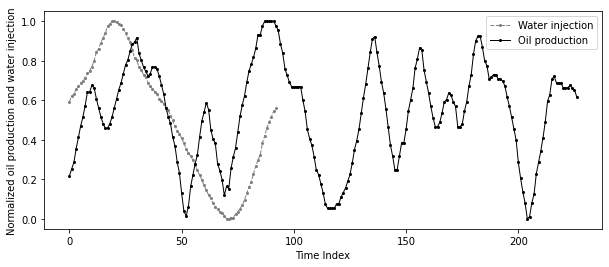

In [4]:
X=df1.to_numpy()
Y=df2.to_numpy()

#Data normlization
X=norm(X)
Y=norm(Y)
time_index=np.arange(0,len(X),1)

#Normalized time series plot 
iny=np.arange(0,len(Y),1)
inx=np.arange(0,len(X),1)
fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1
lns1 =ax1.plot(inx,X,color='gray',linestyle='--',marker='o',markersize='2',linewidth='1',label='Water injection')
lns2 =ax2.plot(iny,Y,color='black',marker='o',markersize='2',linewidth='1',label='Oil production')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.set_xlabel('Time Index')
ax1.set_ylabel('Normalized oil production and water injection',color='black')
plt.show()


In [6]:
X.shape

(93, 1)

#### Cost matrix construction
The comparison between the time series is made using a local distance measure between each pair of elements of the two independent time series. 
$$ C (n,m) =\sqrt{(x_n-y_m)^2} $$

Cost matrix calculation and visualization is the follwing

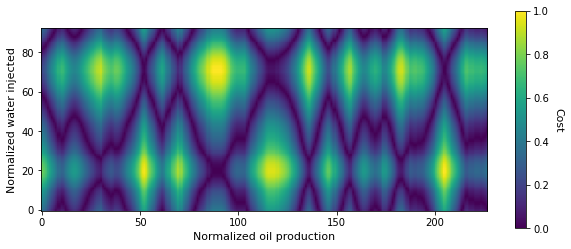

In [18]:
C = scipy.spatial.distance.cdist(X, Y, 'euclidean') 
plt.figure(figsize=(10,4))
im2=plt.imshow(C, origin='lower', aspect='equal',cmap='viridis')
cbar2=plt.colorbar(im2)
cbar2.set_label('Cost', rotation=270, fontsize = 11, labelpad=15)
plt.xlabel('Normalized oil production', fontsize = 11)
plt.ylabel('Normalized water injected', fontsize = 11);

#### Cumulative cost matrix construction

The final objective of the clasical DTW is to find an optimal alignment of low cost within the cost matrix $C(n,m)$  such that it satisfies boundary and monotonicity conditions (Müller, 2007). To find the optimal warping path or global alignment, the classical DTW is based on a recursive computation of an accumulated cost matrix such that satisfies boundary conditions ,monotonicity condition and step size conditions for $0<n≤N$ and $1<m≤M$. The cumulative cost matrix is calulated as follows: 
$$ D(n,0)= \sum_{i=0}^{n}C(x_i,y_0)$$

$$ D(0,m)= C(x_0,y_m)\: for\: m \in [0: M]$$

The remaining values of $D$ are calculated recursively as follows: 

$$ D(n,m)= min\: (D(n-1, m-1),D(n-1, m),D(n, m-1)) + C(n,m) $$ 

Cumulative cost matrix $D(n,m)$ computation

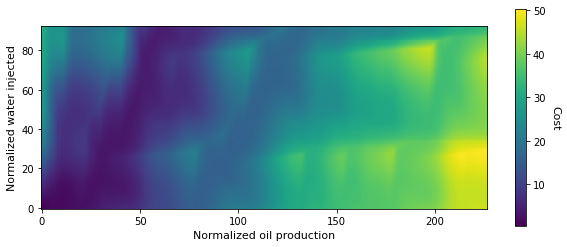

In [19]:
Ds1=compute_accumulated_cost_matrix(C,step_size=1)
#plot cummulative cost matrix
plt.figure(figsize=(10,4))
im3=plt.imshow(Ds1, origin='lower', aspect='equal',cmap='viridis')
cbar2=plt.colorbar(im3)
cbar2.set_label('Cost', rotation=270, fontsize = 11, labelpad=15)
plt.xlabel('Normalized oil production', fontsize = 11)
plt.ylabel('Normalized water injected', fontsize = 11);

#### Optimal warping path calculation

The goal of the clasic subsecuent DTW as mention before if to find the optimal warping path with the lowest cost subjective to boundary, monoticinty and step size conditions. The optimal warping path $P=(p_1,p_2,...p_s)$ is computed in reversed order where the starting point $P_s=(N,b*)$

The optimal warping path calculation is as follows: 
1. Determine the starting point $P_s=(N,b*)$ of the warping path where $b*$ is the global minimun of $D$ at $N$ for $m\in [0: M]  $
2. Given the step size, the next point of the warping path is equal to 
$p_{s-1} =min (D(n-1, m-1),D(n-1, m),D(n, m-1))$
3. Repeat step 2 until $N=0$


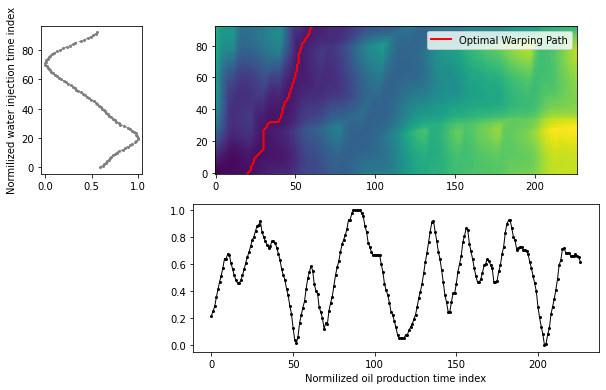

In [20]:
Ps1=compute_optimal_warping_path_subsecuent(Ds1,step_size=1)
optimal_path_plot(X,Y,Ps1, Ds1)

#### Optimal time series aligment

Given the X, Y and the optimal warping path obtain with the clasical DTW algorithm we can find the subsequence of time in the oil production time series that has highest similarity with the water injection signal.

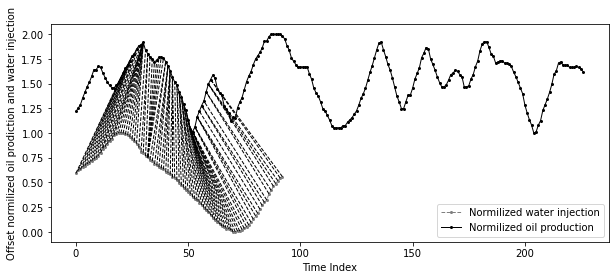

In [21]:
aligment_plot(X,Y,Ps1,1)

The main limitations of the classical DTW for water injection and production history include:
* The classical DTW algorithm matched water injection points with oil production points that are back in time. That is, water injection cannot have a response signal at previous times. 
* The classical DTW causes time singularities on the warping path. That is, several water injection points are matched to a single oil production point and vice versa. 
* The classical DTW match every single point of the water injection to the oil production. There are diffusion effects at the reservoir level, therefore, the water injection signal is attenuated as it travels through the reservoir to the producing well. Therefore, it is expected to have fewer matching points on the oil production signal.  
* The matched sequence in the oil production signal has a lower time length than the original water injection signal. Therefore, because of the diffusivity effects the matched sequence should have at least the same time length as the water injection signal. 


### Fluid flow physics constrain DTW algorithm
Due to those limitations, the classical subsequent DTW is not able to obtain a representative match between the water injection and oil production to estimate the time lag in waterflooding operations. For that reason, in this work we propose implement fluid-flow physics constrains to the classical DTW algorithm to avoid the shortcomings of the classical DTW. The  new constrains in the cummulative cost matrix can be defined as follws:

$$ D(n,1-α)= 0\: for \: n \in [1: N]$$

$$ D(1-α,m)= 0 \: for \: m \in [1: M]$$





$$ D(n,0)= \sum_{i=0}^{n}C(x_i,y_0)$$

$$ D(0,m)= C(x_0,y_m)\: for\: m \in [0: M]$$

$$D(n,m)=\infty \:for \:(n>m)$$

The remaining values of $D$ are calculated recursively as follows: 

$$ D(n,m)= min \: (D(n-1-\alpha, m-1-\alpha)) + C(n,m)\: for m\in [1: M] and n\in [1: N] $$ 


Where α is the hyperparameter that controls the size of the search space. The initialization of the cumulative cost matrix is performed by extending the matrix D with an additional row and column set to 0 depending on the value of the hyperparameter α.
To avoid warping paths falling into times where water injection is earlier that the oil response it is necessary to set future previos observations of the water injection to the oil production to infinity. 

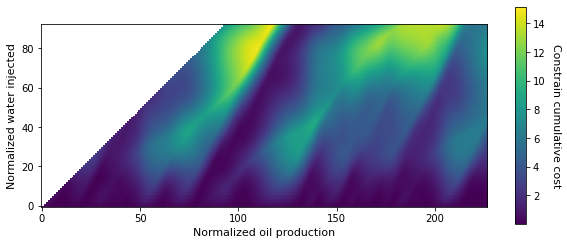

In [22]:
P_cdtw, D_cdtw=dtw_constrain(X,Y,2,19)
#plot cummulative cost matrix
plt.figure(figsize=(10,4))
im3=plt.imshow(D_cdtw, origin='lower', aspect='equal',cmap='viridis')
cbar2=plt.colorbar(im3)
cbar2.set_label('Constrain cumulative cost', rotation=270, fontsize = 11, labelpad=15)
plt.xlabel('Normalized oil production', fontsize = 11)
plt.ylabel('Normalized water injected', fontsize = 11);

The angle θ will limit the search space by allowing only the possible points that fall within the allowed search area during the recursive optimization. The new optimal warpinght path is calculated as follows: 
1. Normalize water injected and oil production time series using min max normalization. 
2. Construct the cost matrix $C(x,y)$
3. Initialize and construct the cumulative cost matrix $D(n,m)$
4. Select a hyperparameter $α$ and recursively build the cumulative cost matrix $D$
5. Determine the starting point $b*$ of the warping $P_l (N,b*)$ as the global minimum of the N row in the constrained $D$ matrix
6. Perform dynamic optimization on the resulting cumulative D matrix to find the final point of the warped sequence $a*$. 
7. Determine the lag time between water injection and oil production as the difference of the beginning of the injection and the optimal warping path. 


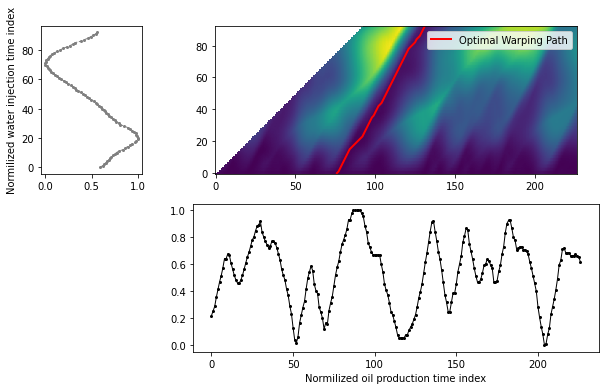

In [23]:
optimal_path_plot(X,Y,P_cdtw,D_cdtw)

 Optimal aligment using the constrained DTW algorithm 

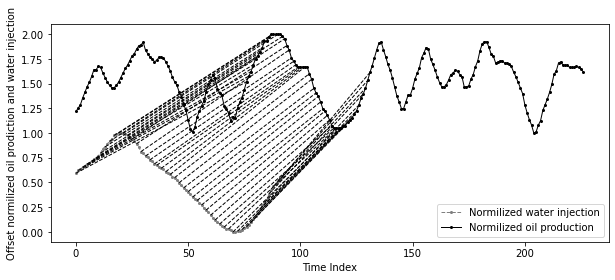

In [24]:
aligment_plot(X,Y,P_cdtw,1)

Using specifict constrains during the construction of the cumulative cost matrix and the optimization algorithm we overcome the shortcomes of the clasical DTW algorithm when applied to water injection and oil production data. 

### Hyperparater Tunning

The following is the proposed methodology to select appropiate values of  θ and α. 
1. Determine the hyperparatemer search space as a range of values for θ going from 1 to 45. θ represents the maximum apperture from a 45 degree line. The value of α goest from 2 as the minimul value to at leat the half of the points of the length of the water injection time series. 
2. For each optimal warping path we evaluate 4 different metrixcs. Mean squared error, warping path cost, cosine similarity between the oringal water signal and the optimal match sequecen and the total number of matched points.
3. The optimal values for θ and α are selected as the ones with the lowest MSE and the larges number of matched points

In [25]:
### Hyperparameter tunning
ang=np.arange(4,44,5)
ss=np.arange(2,22,4)
cost=[]
mse=[]
cosim=[]
matched_points=[]
for i in ss:
    for j in ang:
        P_norm, D_norm=dtw_constrain(X,Y,i,j)
        matched_points.append(len(P_norm))        
        C_pn = scipy.spatial.distance.cdist(X,Y, 'euclidean')
        wpc=[]
        for (n, m) in P_norm:
            wpc.append(C_pn[n, m])
        c_P=np.sum(wpc)
        cost.append(c_P)
        
        match_X=[]
        match_Y=[]
        for k in range(len(P_norm)):
            match_X.append(X[P_norm[:,0][k]])
            match_Y.append(Y[P_norm[:,1][k]])
        err=mean_squared_error(match_X,match_Y)
        mse.append(err)
        
        u=np.array(match_X).reshape(-1,)
        v=np.array(match_Y).reshape(-1,)
    
        simm=cosine_similarity(u, v)
        print ('Omega: ',i,'Alpha: ',j, 'Cost: ',c_P, 'MSE: ',err,'Cosine Simularity: ',simm)
        cosim.append(simm)


Omega:  2 Alpha:  4 Cost:  20.70243135373761 MSE:  0.16175717969777662 Cosine Simularity:  0.7044395399098552
Omega:  2 Alpha:  9 Cost:  20.70243135373761 MSE:  0.16175717969777662 Cosine Simularity:  0.7044395399098552
Omega:  2 Alpha:  14 Cost:  20.70243135373761 MSE:  0.16175717969777662 Cosine Simularity:  0.7044395399098552
Omega:  2 Alpha:  19 Cost:  1.0158905388447788 MSE:  0.0008979381021857266 Cosine Simularity:  0.998819469351868
Omega:  2 Alpha:  24 Cost:  1.0158905388447788 MSE:  0.0008979381021857266 Cosine Simularity:  0.998819469351868
Omega:  2 Alpha:  29 Cost:  1.0158905388447788 MSE:  0.0008979381021857266 Cosine Simularity:  0.998819469351868
Omega:  2 Alpha:  34 Cost:  1.0158905388447788 MSE:  0.0008979381021857266 Cosine Simularity:  0.998819469351868
Omega:  2 Alpha:  39 Cost:  1.0158905388447788 MSE:  0.0008979381021857266 Cosine Simularity:  0.998819469351868
Omega:  6 Alpha:  4 Cost:  10.626760351598197 MSE:  0.12289233633231217 Cosine Simularity:  0.7890064340

#### Results from Hyperparater tunning 

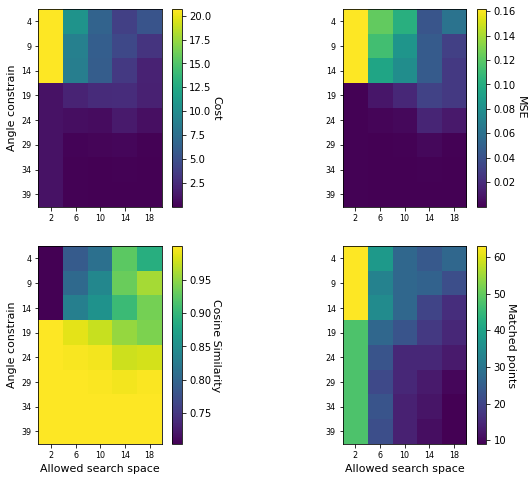

In [26]:
cost=np.array(cost).reshape(len(ss),len(ang))
mse=np.array(mse).reshape(len(ss),len(ang))
sim=np.array(cosim).reshape(len(ss),len(ang))
matched_points=np.array(matched_points).reshape(len(ss),len(ang))
hyperparameter_tunning_plots(cost,mse,sim,matched_points)

For this demostration. The optimal values for  θ and α are 19 and 2 respectively. As they have the largest number of matched points while having the lowest MSE and the matched time sequences have the largest similarity. 
From here, we can determne the time lag as the time difference between the original water injection sequence and the subsequence time series matched in the oil production signal. 

In [56]:
time_lag=[]
for i in range(len(P_cdtw)):
    time_lag.append(P_cdtw[:,1][i]-P_cdtw[:,0][i])
print ('Mean lag time between water injection and oil production: ',round(np.mean(np.array(time_lag)),2),'Months')
print ('Water break-trhought time :',np.min(np.array(time_lag)),'Months')

Mean lag time between water injection and oil production:  58.08 Months
Water break-trhought time : 39 Months


### Summary and key points

* The implementation of specific constraints for cDTW allows one to determine the water injection effect on oil production history. 
* FPC-DTW algorithm is robust with noise levels up to SNR to 0.90 for selecting optimal warping paths as compared with noise-free signals. 
* The final optimal warping path obtained from FPC-DTW can be used to estimate the expected time lag between water injection and oil production signals as well as the estimated breakthrough time as shown in the field case scenario without the need of a geological model.
* A methodology for selecting the optimal hyperparameters 𝛼 and θ was proposed as the combination that provides the best evaluation metrics while retaining the largest number of matched points. 
* Method only uses production and injection data

* The next steps include investigate the influence of several injector and producer wells at the same time. Additionally, if bottomhole pressure is available. FPC-DTW is flexible, and it can be implemented with pressure signals to reduce uncertainty on the water breakthrough and lag time estimates. The proposed algorithm can be used to evaluate reservoir heterogeneity characterization using lag times with the final objective to estimate lag time in unknown locations of the filed to optimize water flooding well location. 
